In [2]:
# in this notebook we will try to understand the grokking and double descent phenomena for simple neural networks trained 
# on a modular addition task.
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')


p = 71 # prime number for modular addition
frac_train=2/3 # fraction of the dataset to be used for training

In [3]:
# equivalent of repeat for torch
repeat = lambda x, n: x.unsqueeze(1).expand(-1, n).reshape(-1)

In [4]:
a = repeat(torch.arange(p), p)
b = torch.stack([torch.arange(p)]*p, dim=0).reshape(-1)
# transforrm a and b to one-hots
a_onehot = torch.zeros(p*p, p)
a_onehot[torch.arange(p*p), a] = 1
b_onehot = torch.zeros(p*p, p)
b_onehot[torch.arange(p*p), b] = 1


In [5]:
dataset=torch.stack([a_onehot, b_onehot], dim=1).float().cuda()
print('dataset shape:', dataset.shape)

labels = (a+b)%p
print(labels[:8])
# compute the one-hot encoding of the labels
labels_onehot = torch.zeros(p*p, p).cuda()
labels_onehot[torch.arange(p*p), labels] = 1
labels_onehot = labels_onehot

dataset shape: torch.Size([5041, 2, 71])
tensor([0, 1, 2, 3, 4, 5, 6, 7])


In [6]:
indices = torch.randperm(p**2)
cutoff = int(p**2*frac_train)
train_indices = indices[:cutoff]
test_indices = indices[cutoff:]

train_dataset = dataset[train_indices]
test_dataset = dataset[test_indices]
train_labels = labels_onehot[train_indices]
test_labels = labels_onehot[test_indices]

print('train dataset shape:', train_dataset.shape)
print('test dataset shape:', test_dataset.shape)
print('train labels shape:', train_labels.shape)
print('test labels shape:', test_labels.shape)

train dataset shape: torch.Size([3360, 2, 71])
test dataset shape: torch.Size([1681, 2, 71])
train labels shape: torch.Size([3360, 71])
test labels shape: torch.Size([1681, 71])


In [19]:
# we will use a simple 2 layer neural network with 10 hidden units
class Net3(nn.Module):
    def __init__(self, hidden_units=100):
        super(Net3, self).__init__()
        self.fca = nn.Linear(p, hidden_units//2)
        self.fcb = nn.Linear(p, hidden_units//2)
        self.fc2 = nn.Linear(hidden_units,hidden_units)
        self.fc3 = nn.Linear(hidden_units,p)

    def forward(self, x):
        xa = x[:,0,:]
        xb = x[:,1,:]
        ha = self.fca(xa)
        hb = self.fcb(xb)
        h = F.relu(torch.cat([ha, hb], dim=1))
        x = self.fc2(h)
        x = F.relu(x)
        x = self.fc3(x)
        return x
        
class Net2(nn.Module):
    def __init__(self, hidden_units=100):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(2*p, hidden_units)
        self.fc2 = nn.Linear(hidden_units,p)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        h = (self.fc1(x))**2
        #h = F.leaky_relu(self.fc1(x))
        x = self.fc2(h)
        return x

In [20]:
train_dataset.shape

torch.Size([3360, 2, 71])

In [21]:
train_labels[:5]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 

In [22]:
# Let's train now
net = Net2(hidden_units=400).cuda()
# initialize network parameters
for p_ in net.parameters():
    print(p_.shape)
    if p_.dim() > 1:
        nn.init.xavier_uniform_(p_)
# print number of parameters
print('number of parameters:', sum(p.numel() for p in net.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
# optimize with weight decay
wd = 1e-4
optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=wd)
#optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=wd)
num_epochs = 10000
train_losses = []
accuracies_train = []
accuracies_test = []
test_losses = []
weight_norms = []

for epoch in range(num_epochs):  # loop over the dataset multiple times
    running_loss = 0.0
    net.train()
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs = net(train_dataset)
    loss = criterion(outputs, train_labels)
    
    accuracies_train.append(torch.argmax(outputs, dim=1).eq(torch.argmax(train_labels, dim=1)).float().mean().item())

    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    train_losses.append(running_loss)
    net.eval()
    outputs = net(test_dataset)
    loss = criterion(outputs, test_labels)
    test_losses.append(loss.item())
    accuracies_test.append(torch.argmax(outputs, dim=1).eq(torch.argmax(test_labels, dim=1)).float().mean().item())

    # add norm all the weights (not biases)
    #weight_norms.append(torch.cat([p.flatten() for p in net.parameters() if len(p.shape) > 1]).norm().item())
    weight_norms.append([p.norm().item() for p in net.parameters() if len(p.shape) > 1])

    if epoch % 100 == 0:    # print every 100 epochs
        print('[%d] train loss: %.3f, test loss: %.3f' %
              (epoch + 1, train_losses[-1], test_losses[-1]))

torch.Size([400, 142])
torch.Size([400])
torch.Size([71, 400])
torch.Size([71])
number of parameters: 85671
[1] train loss: 4.263, test loss: 4.274
[101] train loss: 0.026, test loss: 2.768


[201] train loss: 0.017, test loss: 0.166
[301] train loss: 0.014, test loss: 0.070
[401] train loss: 0.013, test loss: 0.057
[501] train loss: 0.013, test loss: 0.049
[601] train loss: 0.012, test loss: 0.039
[701] train loss: 0.012, test loss: 0.031
[801] train loss: 0.011, test loss: 0.026
[901] train loss: 0.011, test loss: 0.024
[1001] train loss: 0.011, test loss: 0.023
[1101] train loss: 0.011, test loss: 0.022
[1201] train loss: 0.011, test loss: 0.022
[1301] train loss: 0.011, test loss: 0.021
[1401] train loss: 0.011, test loss: 0.021
[1501] train loss: 0.011, test loss: 0.021
[1601] train loss: 0.011, test loss: 0.021
[1701] train loss: 0.011, test loss: 0.021
[1801] train loss: 0.011, test loss: 0.021
[1901] train loss: 0.011, test loss: 0.021
[2001] train loss: 0.011, test loss: 0.021
[2101] train loss: 0.011, test loss: 0.021
[2201] train loss: 0.011, test loss: 0.021
[2301] train loss: 0.011, test loss: 0.021
[2401] train loss: 0.011, test loss: 0.021
[2501] train loss: 

In [23]:
def tonumber(x):
    return (x.cpu()*torch.arange(p)).sum().item()

for i in range(train_dataset.shape[0]):
    #print(f'{i} Tokens:', train_dataset[i,0].cpu(), train_dataset[i,1].cpu(),  train_labels[i].cpu())
    a = tonumber(train_dataset[i,0])
    b = tonumber(train_dataset[i,1])
    pred = torch.argmax(net(train_dataset[i:i+1]), dim=1).item()
    print(f'{i} Numbers: {int(a)}+{int(b)}={pred}',  tonumber(train_labels[i]), f'True={(a+b)%p}')


0 Numbers: 70+45=44 44.0 True=44.0
1 Numbers: 14+28=42 42.0 True=42.0
2 Numbers: 28+66=23 23.0 True=23.0
3 Numbers: 45+67=41 41.0 True=41.0
4 Numbers: 48+51=28 28.0 True=28.0
5 Numbers: 15+9=24 24.0 True=24.0
6 Numbers: 13+70=12 12.0 True=12.0
7 Numbers: 46+42=17 17.0 True=17.0
8 Numbers: 69+63=61 61.0 True=61.0
9 Numbers: 34+36=70 70.0 True=70.0
10 Numbers: 49+9=58 58.0 True=58.0
11 Numbers: 16+3=19 19.0 True=19.0
12 Numbers: 14+1=15 15.0 True=15.0
13 Numbers: 3+45=48 48.0 True=48.0
14 Numbers: 18+66=13 13.0 True=13.0
15 Numbers: 68+1=69 69.0 True=69.0
16 Numbers: 26+55=10 10.0 True=10.0
17 Numbers: 40+59=28 28.0 True=28.0
18 Numbers: 27+24=51 51.0 True=51.0
19 Numbers: 42+26=68 68.0 True=68.0
20 Numbers: 28+53=10 10.0 True=10.0
21 Numbers: 12+61=2 2.0 True=2.0
22 Numbers: 4+65=69 69.0 True=69.0
23 Numbers: 14+29=43 43.0 True=43.0
24 Numbers: 36+38=3 3.0 True=3.0
25 Numbers: 19+36=55 55.0 True=55.0
26 Numbers: 28+14=42 42.0 True=42.0
27 Numbers: 14+49=63 63.0 True=63.0
28 Numbers: 15+

525 Numbers: 52+3=55 55.0 True=55.0
526 Numbers: 58+6=64 64.0 True=64.0
527 Numbers: 38+50=17 17.0 True=17.0
528 Numbers: 42+69=40 40.0 True=40.0
529 Numbers: 43+31=3 3.0 True=3.0
530 Numbers: 32+59=20 20.0 True=20.0
531 Numbers: 22+2=24 24.0 True=24.0
532 Numbers: 35+70=34 34.0 True=34.0
533 Numbers: 3+12=15 15.0 True=15.0
534 Numbers: 69+53=51 51.0 True=51.0
535 Numbers: 10+54=64 64.0 True=64.0
536 Numbers: 36+60=25 25.0 True=25.0
537 Numbers: 31+14=45 45.0 True=45.0
538 Numbers: 70+42=41 41.0 True=41.0
539 Numbers: 5+22=27 27.0 True=27.0
540 Numbers: 46+63=38 38.0 True=38.0
541 Numbers: 7+20=27 27.0 True=27.0
542 Numbers: 51+70=50 50.0 True=50.0
543 Numbers: 62+14=5 5.0 True=5.0
544 Numbers: 10+53=63 63.0 True=63.0
545 Numbers: 43+68=40 40.0 True=40.0
546 Numbers: 5+46=51 51.0 True=51.0
547 Numbers: 24+1=25 25.0 True=25.0
548 Numbers: 16+31=47 47.0 True=47.0
549 Numbers: 35+69=33 33.0 True=33.0
550 Numbers: 52+51=32 32.0 True=32.0
551 Numbers: 49+58=36 36.0 True=36.0
552 Numbers: 64

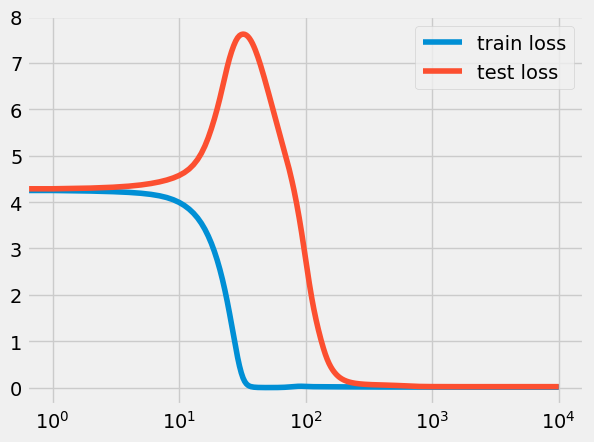

In [24]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.xscale('log')
#plt.yscale('log')

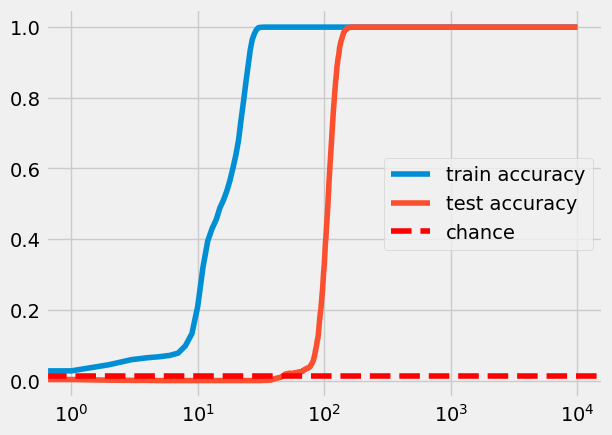

In [25]:
plt.plot(accuracies_train, label='train accuracy')
plt.plot(accuracies_test, label='test accuracy')
plt.axhline(1/p, color='r', linestyle='--', label='chance')
plt.legend()
plt.xscale('log')

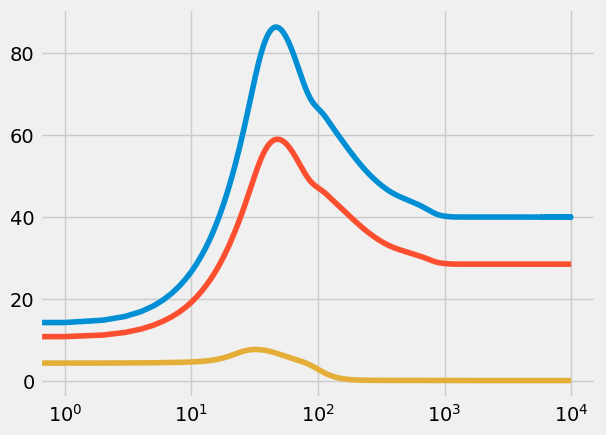

In [26]:
# plot weight norms
weight_norms_np = np.array(weight_norms)
plt.plot(weight_norms_np[:,0], label='layer 1')
plt.plot(weight_norms_np[:,1], label='layer 2')
plt.plot(test_losses, label='test loss')
# plt.yscale('log')
plt.xscale('log')

In [50]:
# extract weights of the network
weights = []
biases = []
for p_ in net.parameters():
    if p_.dim() > 1:
        print(p_.shape)
        if p_.shape[1] == 2*p:
            # separate both inputs
            weights.append(p_[:,:p].detach().cpu().numpy())
            weights.append(p_[:,p:].detach().cpu().numpy())
        else:
            weights.append(p_.detach().cpu().numpy())
    else:
        biases.append(p_.detach().cpu().numpy().flatten())
    

torch.Size([400, 142])
torch.Size([71, 400])


In [51]:
len(weights)

3

In [52]:
for i in range(len(weights)):
    print(weights[i].shape)

(400, 71)
(400, 71)
(71, 400)


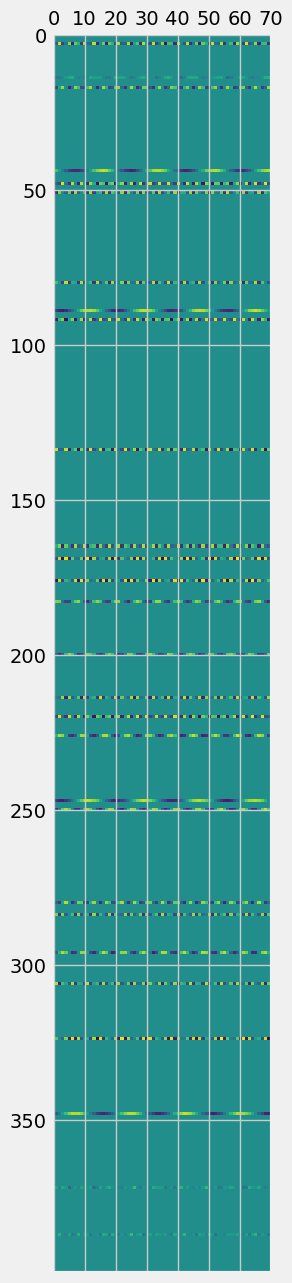

In [53]:
plt.matshow(weights[0])

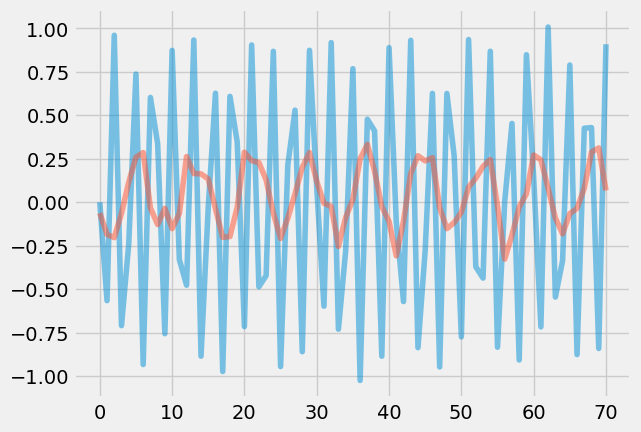

In [56]:
for i in range(15):
    if np.linalg.norm(weights[0][i]) > 0.01:
        plt.plot(weights[0][i], alpha=0.5)

In [67]:
# let's compute the fourier transform of the weights
from scipy.fftpack import fft, fftfreq
fft_weights = fft(weights[0], axis=1)

In [68]:
fft_weights.shape

(400, 71)

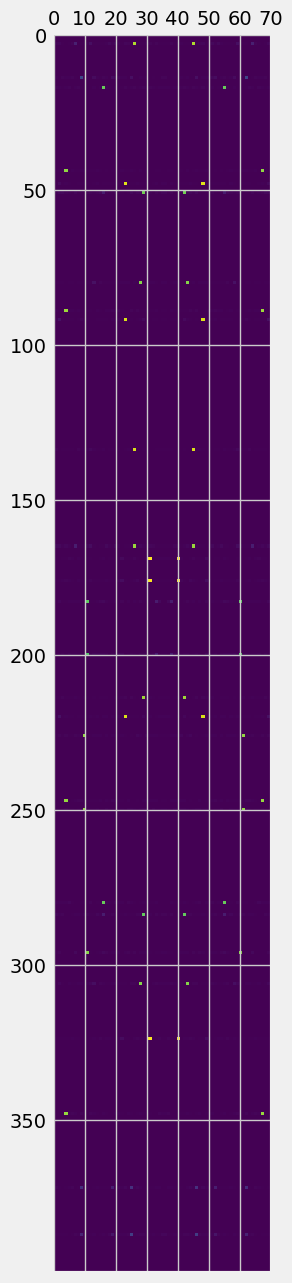

In [69]:
plt.matshow(np.abs(fft_weights))

In [60]:
# Let's compute the normalized power on each dimension
power = np.abs(fft_weights)**2
print(power.shape)

(400, 71)


/tmp/ipykernel_84055/1188627043.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.matshow(np.abs(fft_weights)/np.sqrt(power.sum(axis=1, keepdims=True)))


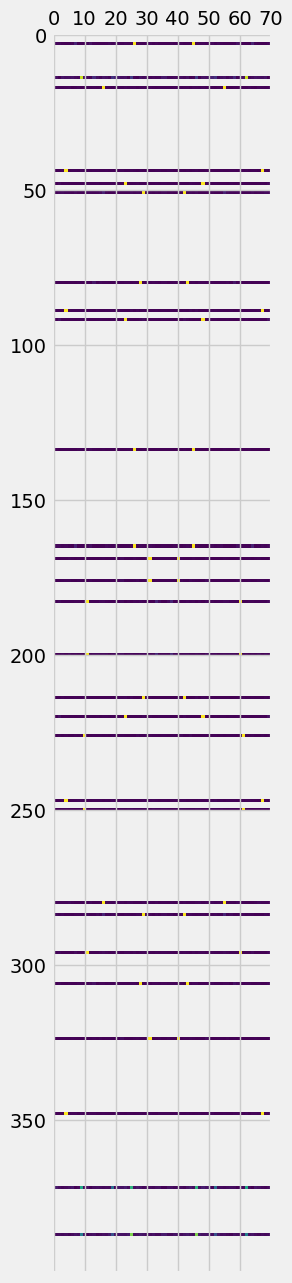

In [61]:
plt.matshow(np.abs(fft_weights)/np.sqrt(power.sum(axis=1, keepdims=True)))

/tmp/ipykernel_84055/1294648525.py:1: RuntimeWarning: invalid value encountered in divide
  normalized_power = np.max(power/power.sum(axis=1, keepdims=True), axis=1)


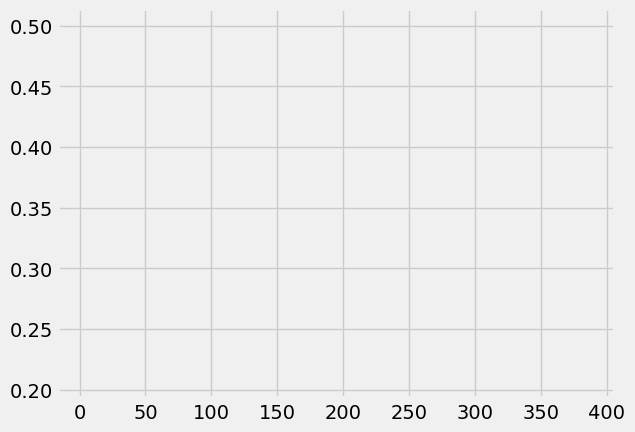

In [62]:
normalized_power = np.max(power/power.sum(axis=1, keepdims=True), axis=1)
plt.plot(normalized_power)

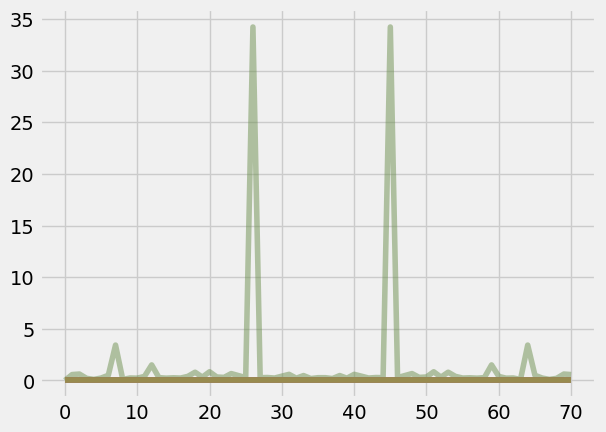

In [63]:
for i in range(10):
    plt.plot(np.abs(fft_weights[i]), alpha=0.5)

In [39]:
biases[0].shape

(400,)

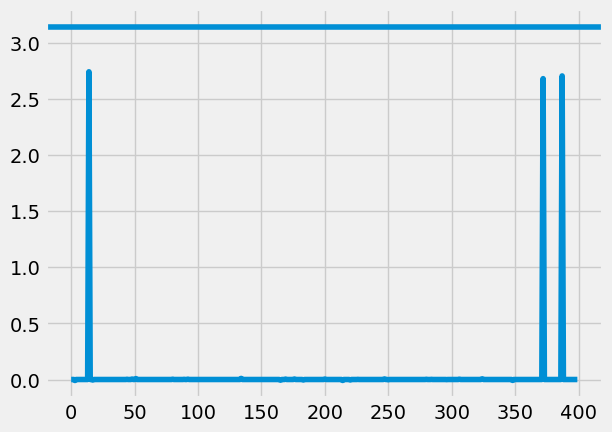

In [40]:
plt.plot(biases[0])
plt.axhline(np.pi)

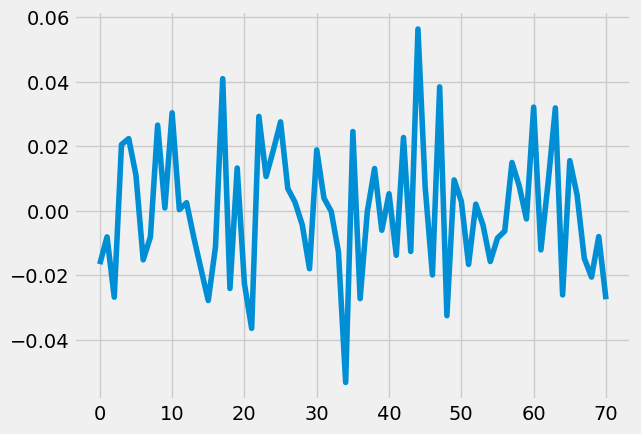

In [41]:
plt.plot(biases[1])

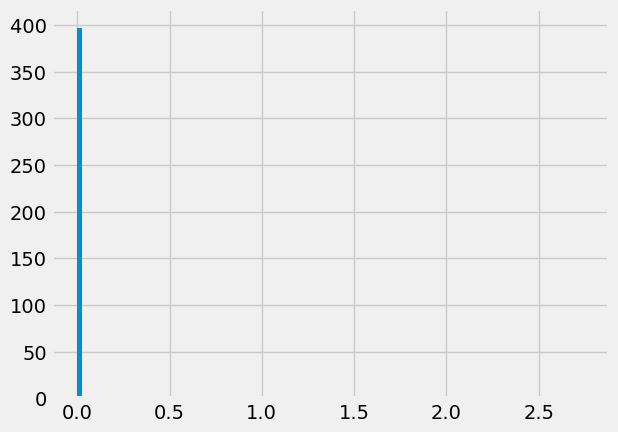

In [42]:
res = plt.hist(np.abs(biases[0]), bins=100)

In [43]:
res[0]

array([397.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,
         1.])

In [44]:
res[1]

array([4.90468475e-41, 2.74263564e-02, 5.48527129e-02, 8.22790712e-02,
       1.09705426e-01, 1.37131780e-01, 1.64558142e-01, 1.91984504e-01,
       2.19410852e-01, 2.46837214e-01, 2.74263561e-01, 3.01689923e-01,
       3.29116285e-01, 3.56542647e-01, 3.83969009e-01, 4.11395371e-01,
       4.38821703e-01, 4.66248065e-01, 4.93674427e-01, 5.21100760e-01,
       5.48527122e-01, 5.75953484e-01, 6.03379846e-01, 6.30806208e-01,
       6.58232570e-01, 6.85658932e-01, 7.13085294e-01, 7.40511656e-01,
       7.67938018e-01, 7.95364380e-01, 8.22790742e-01, 8.50217104e-01,
       8.77643406e-01, 9.05069768e-01, 9.32496130e-01, 9.59922493e-01,
       9.87348855e-01, 1.01477528e+00, 1.04220152e+00, 1.06962788e+00,
       1.09705424e+00, 1.12448061e+00, 1.15190697e+00, 1.17933333e+00,
       1.20675969e+00, 1.23418605e+00, 1.26161242e+00, 1.28903878e+00,
       1.31646514e+00, 1.34389150e+00, 1.37131786e+00, 1.39874423e+00,
       1.42617059e+00, 1.45359695e+00, 1.48102331e+00, 1.50844967e+00,
      

In [57]:
def train(num_epochs=10000, hidden_units=100, wd=1e-4, verbose=False):
    # Let's train now
    net = Net2(hidden_units=hidden_units).cuda()
    # initialize network parameters
    for p_ in net.parameters():
        if p_.dim() > 1:
            nn.init.xavier_uniform_(p_)
    # print number of parameters
    print('number of parameters:', sum(p.numel() for p in net.parameters() if p.requires_grad))

    criterion = nn.CrossEntropyLoss()
    # optimize with weight decay
    #optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.0, weight_decay=1e-3)
    optimizer = optim.Adam(net.parameters(), lr=0.01, weight_decay=wd)
    num_epochs = num_epochs
    train_losses = []
    accuracies_train = []
    accuracies_test = []
    test_losses = []
    weight_norms = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        net.train()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(train_dataset)
        loss = criterion(outputs, train_labels)

        accuracies_train.append(torch.argmax(outputs, dim=1).eq(torch.argmax(train_labels, dim=1)).float().mean().item())

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        train_losses.append(running_loss)
        net.eval()
        outputs = net(test_dataset)
        loss = criterion(outputs, test_labels)
        test_losses.append(loss.item())
        accuracies_test.append(torch.argmax(outputs, dim=1).eq(torch.argmax(test_labels, dim=1)).float().mean().item())

        #all_weigths.append([p_.detach().cpu().numpy() for p_ in net.parameters()])
        # add the norms of the weights (not biases)
        weight_norms.append([torch.norm(p_).item() for p_ in net.parameters() if p_.dim() > 1])

        if epoch % 100 == 0 and verbose:    # print every 100 epochs
            print('[%d] train loss: %.3f, test loss: %.3f' %
                  (epoch + 1, train_losses[-1], test_losses[-1]))
    return train_losses, test_losses, accuracies_train, accuracies_test, weight_norms

In [58]:
# train multiple networks with different hidden sizes
from tqdm import tqdm

#hidden_units = [10, 20, 30, 50, 60, 70, p, 80, 100, 130, 140, 2*p, 150, 200, 500, 1000, train_dataset.shape[0], p**2]
hidden_units = [10, 60, 70, p, 72, 80, 130, 140, 2*p, 144, 150, 1000, train_dataset.shape[0], p**2, 3*p**2]
# log scale hiden units
hidden_units = [int(h) for h in np.logspace(1, 4, 15)]
all_train_losses = []
all_test_losses = []
all_accuracies_train = []
all_accuracies_test = []
all_all_weights = []

for hidden_unit in tqdm(hidden_units):
    print(f'hidden_units={hidden_unit}')
    train_losses, test_losses, accuracies_train, accuracies_test, all_weights = train(num_epochs=10000, hidden_units=hidden_unit)
    all_train_losses.append(train_losses)
    all_test_losses.append(test_losses)
    all_accuracies_train.append(accuracies_train)
    all_accuracies_test.append(accuracies_test)
    all_all_weights.append(all_weights)

  0%|          | 0/15 [00:00<?, ?it/s]

hidden_units=10
number of parameters: 2211


  7%|▋         | 1/15 [00:26<06:09, 26.42s/it]

hidden_units=16
number of parameters: 3495


  7%|▋         | 1/15 [00:45<10:33, 45.25s/it]


KeyboardInterrupt: 

Text(0, 0.5, 'Test loss')

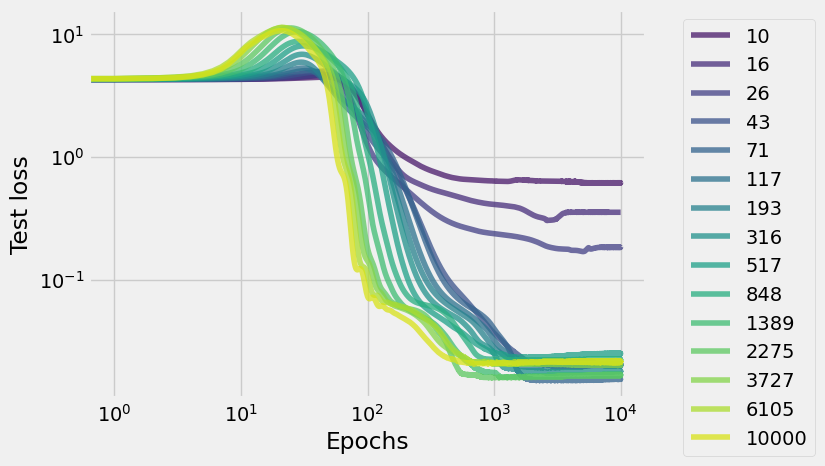

In [ ]:
# let's plot all the train and test losses
# let's use cyclic color palette with a viridis colormap
n = len(hidden_units)
colors = sns.color_palette('viridis', n_colors=n)

for i in range(n):
    plt.plot(all_test_losses[i], label=f'{hidden_units[i]}', color=colors[i], alpha=0.75)
# legend outside of the figure
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('Epochs')
plt.ylabel('Test loss')

(0.005, 1)

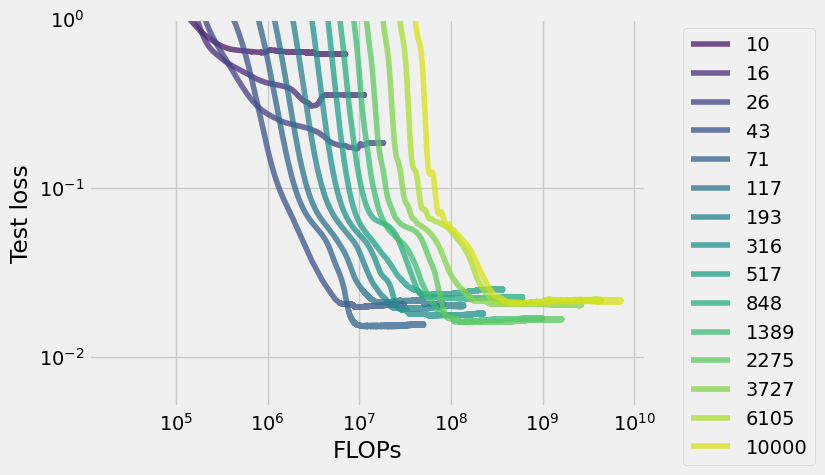

In [ ]:
# No let's do the plot with the FLOPs on the x-axis
# let's plot the test loss on the y axis

# let's compute the number of FLOPs
# we have 2 matrix multiplications and 2 matrix additions per layer
# the first layer has 2*p*hidden_units parameters
# the second layer has hidden_units*p parameters
# the total number of FLOPs at time t is then
# O(t*hiddent_units*p)
# we will ignore the bias terms and the batch size is constant
# we will also ignore the activation functions

n = len(hidden_units)
T = len(all_test_losses[0])
flops = np.zeros((n, T))
for i in range(n):
    for t in range(T):
        flops[i, t] = hidden_units[i]*p*t

# Let's plot each curve (for a given hidden size) with a viridis colorscheme
for i in range(n):
    plt.plot(flops[i, 30:], all_test_losses[i][30:], label=f'{hidden_units[i]}', color=colors[i], alpha=0.75)
plt.yscale('log')
plt.xscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('FLOPs')
plt.ylabel('Test loss')
plt.ylim([5e-3, 1])

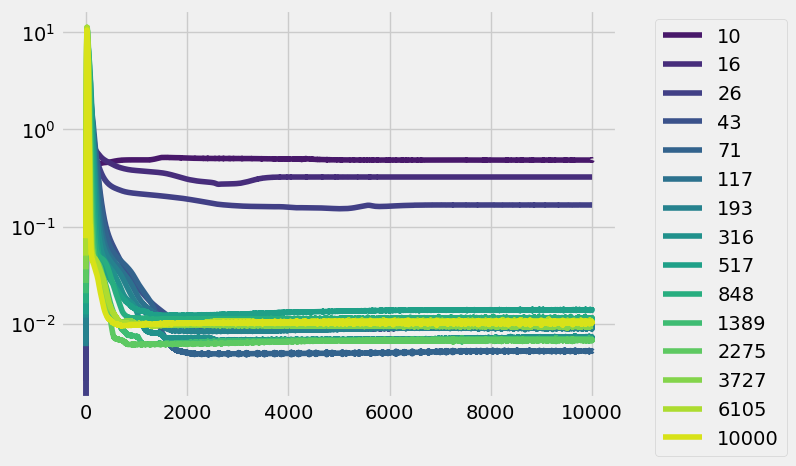

In [ ]:
# Same with the generalization gap now
for i in range(n):
    plt.plot(np.array(all_test_losses[i])-np.array(all_train_losses[i]), label=f'{hidden_units[i]}', color=colors[i])
# legend outside of the figure
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

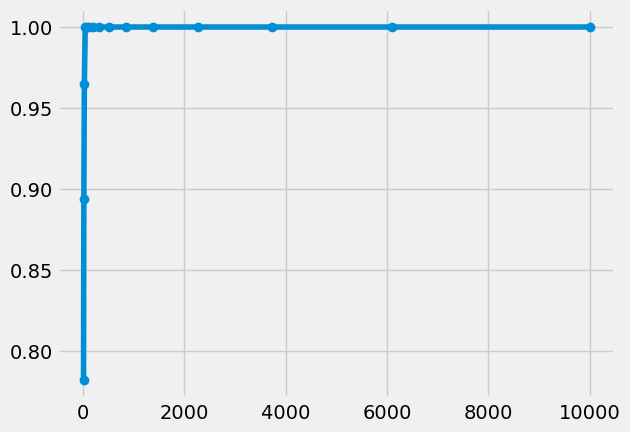

In [ ]:
# Let us now plot the final test accuracy as a function of the number of hidden units
final_accuracies_test = [all_accuracies_test[i][-1] for i in range(n)]
plt.plot(hidden_units, final_accuracies_test, 'o-')

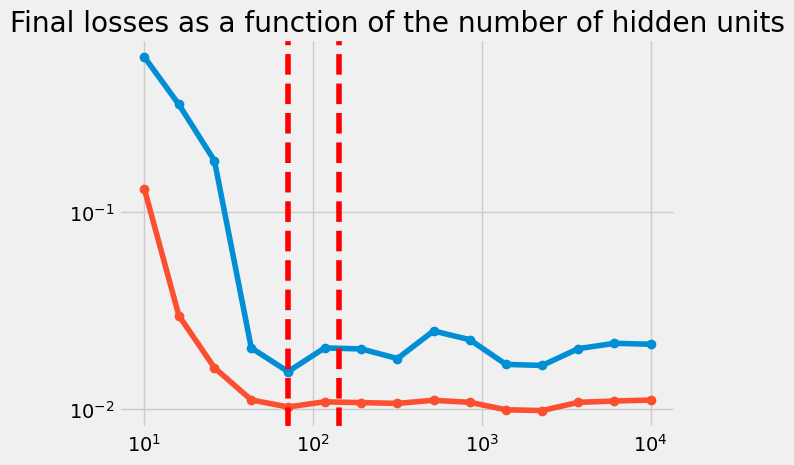

In [ ]:

final_loss_test = [all_test_losses[i][-1] for i in range(n)]
final_loss_train = [all_train_losses[i][-1] for i in range(n)]
plt.plot(hidden_units, final_loss_test, 'o-')
plt.plot(hidden_units, final_loss_train, 'o-')
plt.yscale('log')
plt.xscale('log')
plt.title('Final losses as a function of the number of hidden units')
plt.axvline(p, color='r', linestyle='--')
plt.axvline(2*p, color='r', linestyle='--')

([<matplotlib.axis.XTick at 0x7fb1947df2e0>,
 [Text(0, 0, '10'),
  Text(1, 0, '16'),
  Text(2, 0, '26'),
  Text(3, 0, '43'),
  Text(4, 0, '71'),
  Text(5, 0, '117'),
  Text(6, 0, '193'),
  Text(7, 0, '316'),
  Text(8, 0, '517'),
  Text(9, 0, '848'),
  Text(10, 0, '1389'),
  Text(11, 0, '2275'),
  Text(12, 0, '3727'),
  Text(13, 0, '6105'),
  Text(14, 0, '10000')])

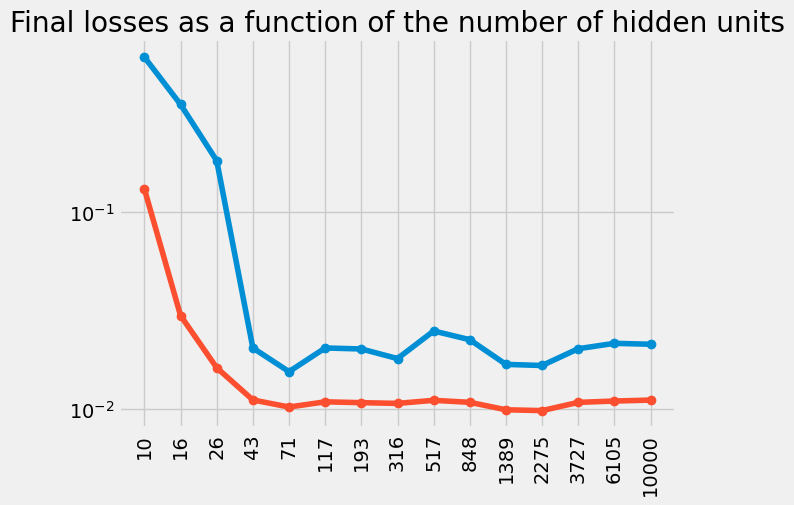

In [ ]:

plt.plot(np.arange(n), final_loss_test, 'o-')
plt.plot(np.arange(n), final_loss_train, 'o-')
plt.yscale('log')
plt.title('Final losses as a function of the number of hidden units')
# and use hidden units for the x axis with set_xticks
plt.xticks(np.arange(n), hidden_units, rotation=90)

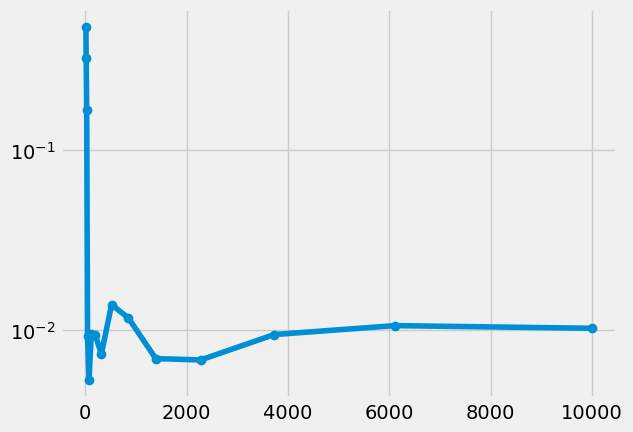

In [ ]:
# we plot the final generalization gap as a function of the number of hidden units
final_loss_test = [all_test_losses[i][-1] for i in range(n)]
final_loss_train = [all_train_losses[i][-1] for i in range(n)]
plt.plot(hidden_units, np.array(final_loss_test)-np.array(final_loss_train), 'o-')
plt.yscale('log')

In [ ]:
all_all_weight_np = np.array(all_all_weights)